# Sentiment binary classification through just one hidden layer definition using Python

In [151]:
def pretty_print_review_and_label(i):
    print(labels[i] + "\t:\t" + reviews[i][:80] + "...") # [:80] limits the number of characters of each review per line

g = open('data/reviews.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1].lower(),g.readlines())) # .lower() methods makes all words lower case for consistent treatment.
g.close()

g = open('data/labels.txt','r') # What we WANT to know!
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

In [153]:
import time
import sys
from collections import Counter # Counter is a convenient fast dictionary that already includes the original keys
import numpy as np


# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, min_count = 10, polarity_cutoff = 0.1, hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            min_count(int) - Words should only be added to the vocabulary 
                             if they occur more than this many times
            polarity_cutoff(float) - The absolute value of a word's positive-to-negative
                                     ratio must be at least this big to be considered.
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get 
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything 
        # is ready for training
        self.pre_process_data(reviews, labels, polarity_cutoff, min_count)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels, polarity_cutoff, min_count):
        ## Calculate positive-to-negative ratios for words before building vocabulary
        positive_counts = Counter()
        negative_counts = Counter()
        total_counts = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(" "):
                    positive_counts[word] += 1
                    total_counts[word] += 1
            else:
                for word in reviews[i].split(" "):
                    negative_counts[word] += 1
                    total_counts[word] += 1

        pos_neg_ratios = Counter()

        for term,cnt in list(total_counts.most_common()):
            if(cnt >= 50): # the pos_neg_ratio ratio is not calculatd for a term that happens less than this count in a huge dataset 
                           # (regarless of being actually very positive or negative in few reviwes) .  
                pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
                pos_neg_ratios[term] = pos_neg_ratio

        for word,ratio in pos_neg_ratios.most_common():
            if(ratio > 1):
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = -np.log((1 / (ratio + 0.01)))
        
        # populate review_vocab with all of the words in the given reviews.
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                # only add words that occur at least min_count times
                # and for words with pos/neg ratios, only add words that meet the polarity_cutoff
                if(total_counts[word] > min_count):
                    if(word in pos_neg_ratios.keys()): # recall that for a word to be in these pos_neg_ratios.keys(),  
                                                       # it should have repeated more than a specific cnt! 
                        if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)
        
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for index, word in enumerate(self.review_vocab):
            self.word2index[word] = index # populate self.word2index with indices for all the words in self.review_vocab
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for index, label in enumerate(self.label_vocab):
            self.label2index[label] = index  
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights
        
        # initialize self.weights_0_1 as a matrix of zeros. 
        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros(shape=(self.input_nodes, self.hidden_nodes))
        
        # initialize self.weights_1_2 as a matrix of random values. 
        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(loc=0.0, scale=self.hidden_nodes**-0.5, size=(self.hidden_nodes, self.output_nodes))
        
        # The input layer, a two-dimensional matrix with shape 1 x hidden_nodes.
        self.layer_1 = np.zeros((1, hidden_nodes))
                
    def get_target_for_label(self,label):
        if (label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1+np.exp(-x)) 
    
    def sigmoid_output_2_derivative(self,output):
        # Return the derivative of the sigmoid activation function, 
        # where "output" is the original output from the sigmoid fucntion 
        return output * (1- output)

    def train(self, training_reviews_raw, training_labels):
        ## pre-process training reviews so we can deal directly with the indices of non-zero inputs
        training_reviews = list()
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                # if the particular word in the review exits in word2index vocabulary, 
                # find its index and add the word index to the indices set
                if (word in self.word2index.keys()):
                    indices.add(self.word2index[word]) # add method works with set
            # at the end of the loop, indices of all words are found from word2index vocabulary.
            # indices set is converted to list and its elements are appended to training_reviews list.
            # TAKE IMPORTANT NOTE that training_reviews is just a list of lists where each list is indices of words for a review.
            training_reviews.append(list(indices))  
        
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        
        # Remember when we started for printing time statistics
        start = time.time()

        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###
            
            # Hidden layer
            # no activation function to preserve the linearity
            ## Add in only the weights for non-zero items
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]            

            # Output layer
            layer_2 = self.sigmoid(np.matmul(self.layer_1, self.weights_1_2))       
              
            #### Implement the backward pass here ####
            ### Backward pass ###
            
            # Output error
            layer_2_error =  self.get_target_for_label(label) - layer_2   
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2) # adjust for the slope of non-linearity
            
            # Backpropagated error
            layer_1_error = np.matmul(layer_2_delta, self.weights_1_2.T) # errors propagated to the hidden layer
            # note in feedforward weights_1_2 is multiplied with layer_1 as input while in backpopogation its transpose 
            # is multiplied with downstream (next layer) error term as the input.
            layer_1_delta = layer_1_error * 1 # hidden layer gradients - no nonlinearity so it's the same as the error (no adjustment)
            
            # update weights   
            self.weights_1_2 += self.learning_rate * layer_2_delta * self.layer_1.T # update hidden-to-output weights with gradient descent step

            ## Only update the weights that were used in the forward pass
            for index in review:
                self.weights_0_1[index] += self.learning_rate * layer_1_delta[0] # update input-to-hidden weights with gradient descent step
            
            # Keep track of corrcet label predictions
            # how accurate are the predictions
            if abs(layer_2_error) < 0.5:
                correct_so_far += 1
            
            # how fast we are training    
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0): # every 2500, make a new line
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """

        # Run a forward pass through the network, like in the "train" function.

        # Hidden Layer
        ## Identify the indices used in the review and then add just those weights to layer_1 
        self.layer_1 *= 0
        unique_indices = set()
        for word in review.lower().split(" "):
            if word in self.word2index.keys():
                unique_indices.add(self.word2index[word])
        for index in unique_indices:
            self.layer_1 += self.weights_0_1[index]
        
        # Output Layer
        layer_2 = self.sigmoid(np.matmul(self.layer_1, self.weights_1_2))
        
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

In [155]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(reviews)*split_frac)
train_x, remaining_x = reviews[:split_idx], reviews[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

In [157]:
# instantiate the model
mlp_full = SentimentNetwork(reviews[:split_idx],labels[:split_idx],min_count=250,polarity_cutoff=0.5,learning_rate=0.01)

# start the clock
start_time = time.time()
# call th etrain function

mlp_full.train(reviews[:split_idx],labels[:split_idx])
# print the training time
print("\nTotal training time is %s minutes." % round((time.time() - start_time) / 60, 3))

Progress:0.0% Speed(reviews/sec):0 #Correct:0 #Trained:1 Training Accuracy:0.0%
Progress:12.5% Speed(reviews/sec):8422. #Correct:2023 #Trained:2501 Training Accuracy:80.8%
Progress:25.0% Speed(reviews/sec):7505. #Correct:4039 #Trained:5001 Training Accuracy:80.7%
Progress:37.5% Speed(reviews/sec):7608. #Correct:6109 #Trained:7501 Training Accuracy:81.4%
Progress:50.0% Speed(reviews/sec):7614. #Correct:8200 #Trained:10001 Training Accuracy:81.9%
Progress:62.5% Speed(reviews/sec):7662. #Correct:10342 #Trained:12501 Training Accuracy:82.7%
Progress:75.0% Speed(reviews/sec):7583. #Correct:12436 #Trained:15001 Training Accuracy:82.9%
Progress:87.5% Speed(reviews/sec):7469. #Correct:14536 #Trained:17501 Training Accuracy:83.0%
Progress:99.9% Speed(reviews/sec):7485. #Correct:16681 #Trained:20000 Training Accuracy:83.4%
Total training time is 0.065 minutes.


In [158]:
mlp.test(reviews[split_idx:],labels[split_idx:])

Progress:99.9% Speed(reviews/sec):5558. #Correct:4356 #Tested:5000 Testing Accuracy:87.1%

# Alternative solution: Sentiment Analysis with an RNN - LSTM

In [160]:
# read data from text files
with open('data/reviews.txt', 'r') as f:
    reviews = f.read()
with open('data/labels.txt', 'r') as f:
    labels = f.read()

### Data pre-processing

In [161]:
from string import punctuation
from collections import Counter

# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])

# split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()

## Encoding the words
## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True) # the most common word mapped to the integer value 1 
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} # start from 1 expilicitly stated

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

## Encoding the labels
# 1=positive, 0=negative label conversion
labels_split = labels.split('\n')
encoded_labels = np.array([1 if label == 'positive' else 0 for label in labels_split])

## Removing Outliers
## remove any reviews/labels with zero length from the reviews_ints list.

# get indices of any reviews with length of not 0 that we want to keep
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length reviews and their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

## Padding sequences
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

### Training, Validation, Test

In [162]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features) * split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

valid_frac = 0.5
test_idx = int(len(remaining_x) * valid_frac)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

In [163]:
## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


### DataLoaders and Batching

In [164]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Sentiment Network with PyTorch

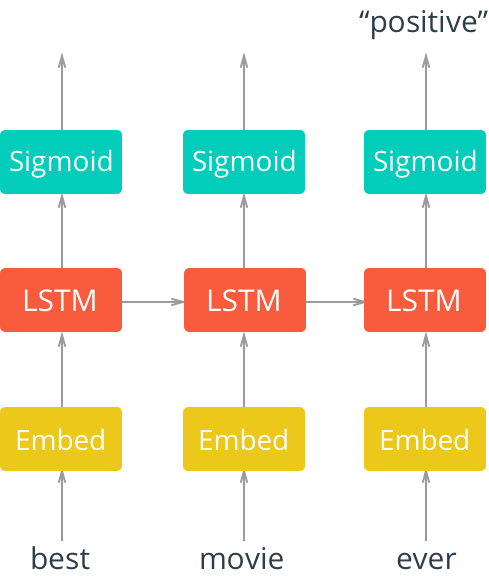

In [130]:
from IPython.display import Image
Image(filename='assets/network_diagram.png')

In [131]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


### Model definition

In [165]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [166]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # our word tokens +1 for the 0-token added to pad input features +
output_size = 1 # a single sigmoid value between 0 and 1  
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [167]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [169]:
# training params
start = time.time()
epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.detach() for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.detach() for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            
print("\nTotal training time is %s minutes." % round((time.time() - start_time) / 60, 3))

Epoch: 1/4... Step: 100... Loss: 0.574357... Val Loss: 0.592211
Epoch: 1/4... Step: 200... Loss: 0.594059... Val Loss: 0.663425
Epoch: 1/4... Step: 300... Loss: 0.523350... Val Loss: 0.585923
Epoch: 1/4... Step: 400... Loss: 0.554656... Val Loss: 0.571660
Epoch: 2/4... Step: 500... Loss: 0.521586... Val Loss: 0.575272
Epoch: 2/4... Step: 600... Loss: 0.357778... Val Loss: 0.509176
Epoch: 2/4... Step: 700... Loss: 0.385232... Val Loss: 0.525697
Epoch: 2/4... Step: 800... Loss: 0.406087... Val Loss: 0.461405
Epoch: 3/4... Step: 900... Loss: 0.305346... Val Loss: 0.490994
Epoch: 3/4... Step: 1000... Loss: 0.224487... Val Loss: 0.455219
Epoch: 3/4... Step: 1100... Loss: 0.340713... Val Loss: 0.462203
Epoch: 3/4... Step: 1200... Loss: 0.231399... Val Loss: 0.469280
Epoch: 4/4... Step: 1300... Loss: 0.108195... Val Loss: 0.480258
Epoch: 4/4... Step: 1400... Loss: 0.201755... Val Loss: 0.509962
Epoch: 4/4... Step: 1500... Loss: 0.165618... Val Loss: 0.505271
Epoch: 4/4... Step: 1600... Loss: 

### Testing

In [170]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.detach() for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.578
Test accuracy: 0.788
